In [1]:
import torch
import pandas as pd
from torch import nn
from d2l import torch as d2l
import numpy as np
import os
from PIL import Image
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
from torchvision import models
from IPython.display import display
import torch.utils.data as Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

train_path = '../../hard_disk/classify-leaves/train.csv'
test_path = '../../hard_disk/classify-leaves/test.csv'
image_path = '../../hard_disk/classify-leaves/'

train=pd.read_csv(train_path)
# class_to_num = dict(zip(list(train.loc[:, 'label'].unique()), range(len(train.label.unique())) ))
# num_to_class = {y: x for x, y in class_to_num.items()}

def get_train_transforms():
    return albumentations.Compose(
        [
            #albumentations.Resize(320, 320),

            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(),
            albumentations.ShiftScaleRotate(
                shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            ),
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            #albumentations.Resize(320, 320),

            # albumentations.HorizontalFlip(p=0.5),
            # albumentations.VerticalFlip(p=0.5),
            # albumentations.Rotate(limit=180, p=0.7),
            # albumentations.RandomBrightnessContrast(),
            # albumentations.ShiftScaleRotate(
            #     shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            # ),
            albumentations.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0),
        ]
    )

# class LeafDataset(Data.Dataset):
#     def __init__(self, data_info,file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform
#         self.data_info=data_info
#         self.train_image = self.data_info.loc[:, 'image'].to_numpy()
#         self.train_label = self.data_info.loc[:, 'label'].to_numpy()

#     def __len__(self):
#         return  len(self.train_image)

#     def __getitem__(self, index):
#         #print(self.train_label)
#         image_path = self.train_image[index]
#         image = np.asarray(Image.open(os.path.join(self.file_path, image_path))) 
#         image=self.transform(image=image)['image']
#         label = self.train_label[index]
#         label_num = class_to_num[label]
#         return image,label_num


In [2]:
# import os
# print(os.getcwd())

In [3]:
le = LabelEncoder()
train['label']=le.fit_transform(train['label'])

class LeaveDataset(Data.Dataset):
    def __init__(self,data,lable,file_path,transform=None):
        self.data = data
        self.label=lable
        self.transform = transform
        self.file_path=file_path

    def __getitem__(self, index):
        data_path = self.data[index]
        data = np.asarray(Image.open(os.path.join(self.file_path,data_path)))
        if self.transform :
            data=self.transform(image=data)['image']
        label = self.label[index]
        return data, label
    
    def __len__(self):
        return  len(self.label)


In [4]:
# def K_fold(k,i,X,y):
#     assert k > 1
#     fold_size = X.shape[0] // k
#     train_data=None
#     for j in range(k):
#         idx = slice(j * fold_size, (j + 1) * fold_size)
#         data_part, label_part = X[idx, :], y[idx]
#         if j == i:
#             valid_data, valid_label = data_part, label_part
#         elif train_data is None:
#             train_data, train_label = data_part, label_part
#         else:
#             train_data = torch.cat([train_data,data_part],0)
#             train_label = torch.cat([label_part,data_part],0)
    
#     return train_data, train_label, valid_data, valid_label
  
# def K_fold_train(k,net,,train,num_epochs,lr,device):
#     for i in range(k):
#         data = K_fold(k,i,x,y)

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
        #print(m.weight.data.dtype)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X=X.to(torch.float32)
            #y=y.float()
            #print(X.type)
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            #print(l)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}', f'test acc {test_acc:.3f}')

    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    print(f'{timer.sum()} sec')


In [6]:
def init_weight(m):
     if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

def right_num(y_hat, y):  #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
        
    def add(self,*args):
        self.data=[a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def my_train(net,train_iter,test_iter,num_epochs,lr,device):
    net.apply(init_weight)
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters() ,lr=lr)
    lr_period, lr_decay = 4, 0.9
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=60,eta_min=0.1)
    loss = nn.CrossEntropyLoss()
    num_batches = len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(3)
        #scheduler.step()
        for i,(X,y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)       
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        scheduler.step()
        
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    return train_l,train_acc,test_acc
    #print(f'loss {train_l:.3f}, train acc {train_acc:.3f}', f'test acc {test_acc:.3f}')          

In [7]:
def my_k_train(k,net,train,num_epochs,lr,device,batch_size):
    kfold = StratifiedKFold(n_splits=k,random_state=42, shuffle=True)
    for i, (train_index, valid_index) in enumerate(kfold.split(train['image'],train['label'])):
        if i == 0 :
            train_data,train_label=train['image'][train_index],train['label'][train_index]
            valid_data,valid_label=train['image'][valid_index],train['label'][valid_index]
            train_dataset = LeaveDataset(train_data.values,train_label.values,image_path, get_train_transforms())
            valid_dataset = LeaveDataset(valid_data.values,valid_label.values, image_path, get_valid_transforms())
            train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size,num_workers=8,shuffle=True)
            valid_loader = Data.DataLoader(dataset=valid_dataset, batch_size=batch_size,num_workers=8)
            train_l,train_acc,test_acc=my_train(net,train_loader,valid_loader,num_epochs,lr,device)
            #train_ch6(net, train_loader, valid_loader, num_epochs, lr, device)
            print(f'The {i}th loss {train_l:.3f}, train acc {train_acc:.3f}', f'test acc {test_acc:.3f}')    

In [8]:
def mynet():
    net = nn.Sequential(
        # 这里使用一个11*11的更大窗口来捕捉对象。
        # 同时，步幅为4，以减少输出的高度和宽度。
        # 另外，输出通道的数目远大于LeNet
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 使用三个连续的卷积层和较小的卷积窗口。
        # 除了最后的卷积层，输出通道的数量进一步增加。W
        # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
        nn.Conv2d(256, 192*2, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(192*2, 192*2, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(192*2, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten()   ,
        # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
        nn.Linear(6*6*256, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
        nn.Linear(4096, 176))
    return net

def resnet():
    net= torchvision.models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    #net= torchvision.models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    #net = torchvision.models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    #net=torchvision.models.seres
    #resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    net.fc = nn.Linear(net.fc.in_features,176)
    nn.init.xavier_uniform_(net.fc.weight)
    return net

In [9]:
# import matplotlib.pyplot as plt
# train_dataset = LeafDataset(train, image_path,get_train_transforms())
# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=False)
# X,y=next(iter(train_loader))
# ex = torch.full((3,224,224), 254,dtype=X.dtype)

# mask = ex != X[0]
# diff_elements = X[0][mask]
# diff_elements
# X=X.to(torch.float32)
# net(X).shape
# loss = nn.CrossEntropyLoss()
# loss(net(X),y)
# X = torch.rand(size=(1, 3, 224, 224), dtype=torch.float32)
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__,'output shape: \t',X.shape)

The 0th loss 0.125, train acc 0.955 test acc 0.950


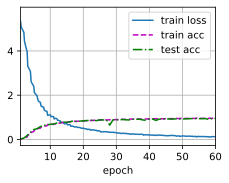

In [10]:

lr, num_epochs,batch_size= 0.0002, 60, 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_dataset = LeafDataset(train, image_path,get_train_transforms())
# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
# train_dataset = LeaveDataset(train['image'],train['label'],image_path,get_train_transforms())
# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
net = resnet()
my_k_train(5,net,train,num_epochs, lr, device, batch_size)
#my_train(net, train_loader, train_loader, num_epochs, lr, device)
#train_ch6(net, train_loader, train_loader, num_epochs, lr, device)

#rint(net)
# for name, param in net.named_parameters():
#     print(name, param.shape)